## Importing Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

## Loading the dataset

In [5]:
fn="./FoDS-Assignment-2.csv"
df=pd.read_csv(fn)
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0


## Dataset Analysis

#### Dataframe Stats

In [ ]:
df.describe()

#### Number of Duplicate data points

In [ ]:
df.duplicated().sum()

#### Number of unique values and null values

In [ ]:
ud=[]
nd=[]
for col in df.columns:
    ud.append(len(pd.unique(df[col])))
    nd.append(df[col].isnull().sum())
df_s={'Feature Number': [0,1,2,3,4,5,6,7,8,9,10,11,12,'Target Attribute'],'Feature Name':df.columns,
        'Number of Unique Values':ud,
     'Number of Null Values':nd}
df_s=pd.DataFrame(df_s)
df_s

#### Correlation Matrix

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data = df.corr(),annot=True)

#### Boxplots

In [ ]:
fig = plt.figure(figsize =(15, 50))
i=1
for s in df.columns:
    plt.subplot(7,4, i)
    plt.title(s)
    plt.grid()
    sns.boxplot(data=df[[s]])
    i=i+1
plt.show()

#### Scatter Plots (Individual Features VS Target Attribute)

In [ ]:
fig = plt.figure(figsize=(40,40))
plt.rc('axes', labelsize=25)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(4,4,i+1)
    plt.scatter(df[col], df["price"])
    plt.xlabel(col)
    plt.ylabel("price")
plt.show()

## Data Preprocessing

In [63]:
class KNN:
  def __init__(self,X):
    self.X = np.array(X)

  def outlier_indices(self, k, threshold):   
    dist = []
    for i in range(0,self.X.shape[0]):
      distance = np.linalg.norm(self.X - self.X[i, :], axis = 1)
      distance[i] = np.Infinity
      dist.append(np.mean(distance[np.argsort(distance)[:k]]))
    return np.squeeze(np.argwhere(np.array(dist) >= threshold)) 

Number of outliers = 138


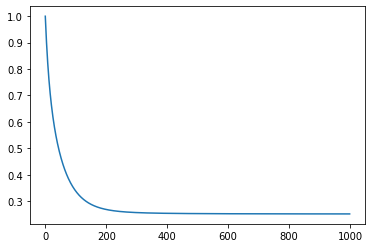

Train MSE 0.25295462994340945
Val MSE 0.1799868626247549
Test MSE 0.1787476246184193


In [154]:
def preprocess(data,f=0.6,scalingMethod="standardize", outlierMethod="knn", knn_k=5, knn_threshold=2, tstd_threshold=2.5, missingValues="drop"):
    EPS = 1e-12

    if missingValues == "drop":
        data = data.dropna()
    elif missingValues == "imputemean":
        for col in data.columns:
            data[col] = data[col].fillna((data[col].mean()))
    else:
        data = data.fillna(0)
    
    if outlierMethod == "knn":
        scaled_data = data.iloc[:,:-1]
        scaled_data = (scaled_data - scaled_data.mean())/scaled_data.std()
        knn = KNN(scaled_data)
        outlier_index = knn.outlier_indices(knn_k, knn_threshold)
        print(f"Number of outliers = {len(outlier_index)}")
        data = data.drop(data.index[outlier_index])
    elif outlierMethod == "tstd":
        target = data.iloc[:,-1]
        target = (target - target.mean())/target.std()
        outlier_index = np.argwhere(target >= tstd_threshold)
        data = data.drop(data.index[outlier_index])
    else:
        pass

    #train test split
    train = data.sample(frac=f, random_state=0)
    val_data = data.drop(train.index)
    val = val_data.sample(frac=0.5, random_state=1)
    test = val_data.drop(val.index)    
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    X_val = val.iloc[:,:-1]
    y_val = val.iloc[:, -1]
    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]
    
    if scalingMethod == "standardize":
        Xmean = X_train.mean()
        Xsd = X_train.std()
        ymean = y_train.mean()
        ysd = y_train.std()
        X_train = (X_train - Xmean) / (Xsd + EPS)
        X_val = (X_val - Xmean) / (Xsd + EPS)
        X_test = (X_test - Xmean) / (Xsd + EPS)
        y_train = (y_train - ymean) / (ysd + EPS)
        y_val = (y_val - ymean) / (ysd + EPS)
        y_test = (y_test - ymean) / (ysd + EPS)
        return np.array(X_train), np.array(y_train).reshape(-1,1), np.array(X_val), np.array(y_val).reshape(-1,1), np.array(X_test), np.array(y_test).reshape(-1,1), Xmean, Xsd, ymean, ysd
    elif scalingMethod == "scale":
        Xminval = X_train.min()
        Xdiff = X_train.max() - X_train.min()
        yminval = y_train.min()
        ydiff = y_train.max() - y_train.min()
        X_train = (X_train - Xminval) / (Xdiff + EPS)
        X_val = (X_train - Xminval) / (Xdiff + EPS)
        X_test = (X_test - Xminval) / (Xdiff + EPS)
        y_train = (y_train - yminval) / (ydiff + EPS)
        y_val = (y_val - yminval) / (ydiff + EPS)
        y_test = (y_test - yminval) / (ydiff + EPS)
        return np.array(X_train), np.array(y_train).reshape(-1,1), np.array(X_val), np.array(y_val).reshape(-1,1), np.array(X_test), np.array(y_test).reshape(-1,1), Xminval, Xdiff, yminval, ydiff
    else:
        return np.array(X_train), np.array(y_train).reshape(-1,1), np.array(X_val), np.array(y_val).reshape(-1,1), np.array(X_test), np.array(y_test).reshape(-1,1), 0, 1, 0, 1

X_train, y_train, X_val, y_val, X_test, y_test, xnum, xdr, ynum, ydr = preprocess(df)
model = LinearRegression(X_train, y_train)
W,b = model.fitGD(lr=0.01, graph=True)
print('Train MSE',model.MSE(y_train, model.predict(X_train)))
print('Val MSE',model.MSE(y_val, model.predict(X_val)))
print('Test MSE',model.MSE(y_test, model.predict(X_test)))

## Linear Regression Model

In [132]:
class LinearRegression:

    def __init__(self, X, y):
            self.X = X #(n,d)
            self.y = y #(n,1)
            self.W = np.zeros((1, X.shape[1])) #(1,d)
            self.b = 1

    def fitGD(self, n_iter=1000, lr=0.01, graph=False):
        mse = []
        for i in range(n_iter):
            yp = self.predict(self.X)
            mse.append(self.MSE(self.y, yp))
            Wgrad = (1/self.X.shape[0])*((self.X.T)@(yp-self.y)).T #(d,n)*(n,1) = (d,1)
            self.W = self.W - lr * Wgrad
            self.b = self.b - lr * np.mean(yp-self.y)
        if(graph == True):
            plt.plot(mse)
            plt.show()
        return self.W, self.b
    
    def predict(self, X):
        return (X@self.W.T + self.b)

    def MSE(self, y, yp):
        return 0.5*np.mean((y-yp)**2)
    
    def RMSE(self, y, yp):
        return np.sqrt(self.MSE(y, yp))

## Feature Selection

In [144]:
def GFFS(X_train, y_train, X_val, y_val, X_test, y_test):
    d = X_train.shape[1]
    remaining = list(range(d))
    selected = []
    train_MSE = []
    val_MSE = []
    test_MSE = []
    for i in range(d):
        print(i+1)
        min_mse = 1e100
        min_mse_val = 1e100
        min_mse_test = 1e100
        min_j = -1
        for j in remaining:
            cur_features = selected + [j]
            X_train_cur = X_train[:,cur_features]
            X_val_cur = X_val[:, cur_features]
            X_test_cur = X_test[:, cur_features]
            model = LinearRegression(X_train_cur, y_train)
            model.fitGD(lr=0.01,n_iter=1000)
            mse = model.MSE(y_train,model.predict(X_train_cur))
            mse_val = model.MSE(y_val,model.predict(X_val_cur))
            mse_test = model.MSE(y_test,model.predict(X_test_cur))
            if mse_val < min_mse_val:
                min_mse = mse
                min_mse_val = mse_val
                min_mse_test = mse_test
                min_j = j
        train_MSE.append(min_mse)
        val_MSE.append(min_mse_val)
        test_MSE.append(min_mse_test)
        selected.append(min_j)
        remaining.remove(min_j)
        print(min_mse,selected)
    return selected, train_MSE, val_MSE, test_MSE
    

In [145]:
def GBFS(X_train, y_train, X_val, y_val, X_test, y_test):
    d = X_train.shape[1]
    removed = [-1]
    selected = list(range(d))
    model = LinearRegression(X_train, y_train)
    model.fitGD(lr=0.01,n_iter=10000)
    train_MSE = [model.MSE(y_train, model.predict(X_train))]
    val_MSE = [model.MSE(y_val, model.predict(X_val))]
    test_MSE = [model.MSE(y_test, model.predict(X_test))]
    for i in range(d-1):
        print(d-i)
        min_mse = 1e100
        min_mse_val = 1e100
        min_mse_test = 1e100
        min_j = -1
        for j in selected:
            cur_features = [x for x in selected if x != j]
            X_train_cur = X_train[:, cur_features]
            X_val_cur = X_val[:, cur_features]
            X_test_cur = X_test[:, cur_features]
            model = LinearRegression(X_train_cur, y_train)
            model.fitGD(lr=0.01,n_iter=1000)
            mse = model.MSE(y_train,model.predict(X_train_cur))
            mse_val = model.MSE(y_val,model.predict(X_val_cur))
            mse_test = model.MSE(y_test,model.predict(X_test_cur))
            if mse_val < min_mse_val:
                min_mse = mse
                min_mse_val = mse_val
                min_mse_test = mse_test
                min_j = j
        train_MSE.append(min_mse)
        val_MSE.append(min_mse_val)
        test_MSE.append(min_mse_test)
        selected.remove(min_j)
        removed.append(min_j)
        print(min_mse, selected)
    removed.append(selected[0])
    return removed, train_MSE, val_MSE, test_MSE    

## Eval Code

### Linear regression model without any pre-processing and feature selection

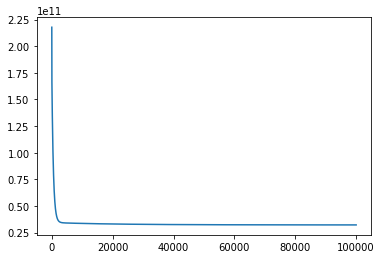

Train MSE 32228592802.096523
Val MSE 45518288007.37285
Test MSE 34354488752.3929


In [161]:
X_train, y_train, X_val, y_val, X_test, y_test, xnum, xdr, ynum, ydr = preprocess(df, scalingMethod=None, outlierMethod=None, missingValues=None)
model = LinearRegression(X_train, y_train)
W,b = model.fitGD(lr=1e-10, n_iter=int(1e5), graph=True)
print('Train MSE',model.MSE(y_train, model.predict(X_train)))
print('Val MSE',model.MSE(y_val, model.predict(X_val)))
print('Test MSE',model.MSE(y_test, model.predict(X_test)))

### Greedy forward feature selection

In [147]:
X_train, y_train, X_val, y_val, X_test, y_test, xnum, xdr, ynum, ydr = preprocess(df)
selected, GFFS_MSE_train, GFFS_MSE_val, GFFS_MSE_test = GFFS(X_train, y_train, X_val, y_val, X_test, y_test)
print(selected)
np.array(df.columns)[selected]

Number of outliers = 138
1
0.32401005490881585 [2]
2
0.28015145165098954 [2, 8]
3
0.2787323076332088 [2, 8, 10]
4
0.2775148926404484 [2, 8, 10, 3]
5
0.27413954394605156 [2, 8, 10, 3, 11]
6
0.26759699182156077 [2, 8, 10, 3, 11, 7]
7
0.26613614274255987 [2, 8, 10, 3, 11, 7, 0]
8
0.26613614274255987 [2, 8, 10, 3, 11, 7, 0, 5]
9
0.26614385303183646 [2, 8, 10, 3, 11, 7, 0, 5, 12]
10
0.2644088367410126 [2, 8, 10, 3, 11, 7, 0, 5, 12, 1]
11
0.2642581281393565 [2, 8, 10, 3, 11, 7, 0, 5, 12, 1, 4]
12
0.2639836905715301 [2, 8, 10, 3, 11, 7, 0, 5, 12, 1, 4, 9]
13
0.25295462994340945 [2, 8, 10, 3, 11, 7, 0, 5, 12, 1, 4, 9, 6]
[2, 8, 10, 3, 11, 7, 0, 5, 12, 1, 4, 9, 6]


array(['sqft_living', 'grade', 'sqft_basement', 'sqft_lot',
       'sqft_living15', 'condition', 'bedrooms', 'waterfront',
       'sqft_lot15', 'bathrooms', 'floors', 'sqft_above', 'view'],
      dtype=object)

In [152]:
f_list1 = []
f1 = []
for i in range(13):
    f_list1.append(selected[i])
    f1.append(np.array(f_list1))
print("Feature Subsets (GFFS)")
pd.DataFrame({'d':[1,2,3,4,5,6,7,8,9,10,11,12,13],
        'Feature Subset': f1,
        'Train MSE': GFFS_MSE_train,
        'Val MSE': GFFS_MSE_val,
        'Test MSE': GFFS_MSE_test
       } )

Feature Subsets (GFFS)


,d,Feature Subset,Train MSE,Val MSE,Test MSE
0,1,[2],0.324010,0.193892,0.198382
1,2,"[2, 8]",0.280151,0.186149,0.201409
2,3,"[2, 8, 10]",0.278732,0.179573,0.196570
3,4,"[2, 8, 10, 3]",0.277515,0.175606,0.195076
4,5,"[2, 8, 10, 3, 11]",0.274140,0.173493,0.192623
5,6,"[2, 8, 10, 3, 11, 7]",0.267597,0.172117,0.185882
6,7,"[2, 8, 10, 3, 11, 7, 0]",0.266136,0.172016,0.189306
7,8,"[2, 8, 10, 3, 11, 7, 0, 5]",0.266136,0.172016,0.189306
8,9,"[2, 8, 10, 3, 11, 7, 0, 5, 12]",0.266144,0.172079,0.189270
9,10,"[2, 8, 10, 3, 11, 7, 0, 5, 12, 1]",0.264409,0.172239,0.190729


### Greedy backward feature selection

In [150]:
X_train, y_train, X_val, y_val, X_test, y_test, xnum, xdr, ynum, ydr = preprocess(df, 0.75, missingValues="imputemean")
removed, GBFS_MSE_train, GBFS_MSE_val, GBFS_MSE_test = GBFS(X_train, y_train, X_val, y_val, X_test, y_test)
print(removed)
np.array(df.columns)[removed[1:]]

Number of outliers = 138
13
0.2513482443793425 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
12
0.25276859236808624 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12]
11
0.25333810560318615 [1, 2, 4, 5, 6, 7, 8, 9, 10, 12]
10
0.2534245566121678 [1, 2, 4, 5, 6, 7, 8, 10, 12]
9
0.2541159812141366 [2, 4, 5, 6, 7, 8, 10, 12]
8
0.25491123634195373 [2, 5, 6, 7, 8, 10, 12]
7
0.25491123634195373 [2, 6, 7, 8, 10, 12]
6
0.25535110861241384 [2, 6, 7, 8, 12]
5
0.2559740883822686 [2, 6, 7, 8]
4
0.2690252529327015 [2, 7, 8]
3
0.31212093121358947 [2, 7]
2
0.3130606408758953 [2]
[-1, 11, 3, 0, 9, 1, 4, 5, 10, 12, 6, 8, 7, 2]


array(['sqft_living15', 'sqft_lot', 'bedrooms', 'sqft_above', 'bathrooms',
       'floors', 'waterfront', 'sqft_basement', 'sqft_lot15', 'view',
       'grade', 'condition', 'sqft_living'], dtype=object)

In [153]:
f_list = np.arange(0,13,1)
f = []
for i in range(1,14):
    f.append(f_list)
    f_list = f_list[f_list != removed[i]]
pd.DataFrame({'d':[13,12,11,10,9,8,7,6,5,4,3,2,1],
        'Feature Subset': f,
        'Train MSE': GBFS_MSE_train,
        'Val MSE': GBFS_MSE_val,
        'Test MSE': GBFS_MSE_test
       } )

,d,Feature Subset,Train MSE,Val MSE,Test MSE
0,13,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.248330,0.173249,0.160088
1,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]",0.251348,0.170032,0.163241
2,11,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12]",0.252769,0.167387,0.162353
3,10,"[1, 2, 4, 5, 6, 7, 8, 9, 10, 12]",0.253338,0.165889,0.160448
4,9,"[1, 2, 4, 5, 6, 7, 8, 10, 12]",0.253425,0.164915,0.160748
5,8,"[2, 4, 5, 6, 7, 8, 10, 12]",0.254116,0.164097,0.162061
6,7,"[2, 5, 6, 7, 8, 10, 12]",0.254911,0.163271,0.159668
7,6,"[2, 6, 7, 8, 10, 12]",0.254911,0.163271,0.159668
8,5,"[2, 6, 7, 8, 12]",0.255351,0.163369,0.162398
9,4,"[2, 6, 7, 8]",0.255974,0.166645,0.165264
